In [1]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

plt.rc('font', family='Malgun Gothic')

import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
test = pd.read_csv('./open/test.csv').drop('ID',axis=1)

In [9]:
train.head(2)

,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),가격
0,2018,2014,skoda,fabia,KAT,SLA,85231,999,0,0,1,0,0,51.74
1,2010,2006,toyota,auris,RKO,SWI,135000,1598,0,0,1,0,0,41.47


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57920 entries, 0 to 57919
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   생산년도         57920 non-null  int64  
 1   모델출시년도       57920 non-null  int64  
 2   브랜드          57920 non-null  object 
 3   차량모델명        57920 non-null  object 
 4   판매도시         57920 non-null  object 
 5   판매구역         57920 non-null  object 
 6   주행거리         57920 non-null  int64  
 7   배기량          57920 non-null  int64  
 8   압축천연가스(CNG)  57920 non-null  int64  
 9   경유           57920 non-null  int64  
 10  가솔린          57920 non-null  int64  
 11  하이브리드        57920 non-null  int64  
 12  액화석유가스(LPG)  57920 non-null  int64  
 13  가격           57920 non-null  float64
dtypes: float64(1), int64(9), object(4)
memory usage: 6.2+ MB


In [10]:
train['연료'] = 0
for col in tqdm(['압축천연가스(CNG)','경유','가솔린','하이브리드','액화석유가스(LPG)']):
    train.loc[train[col]==1,'연료'] = col
train = train.drop(['압축천연가스(CNG)','경유','가솔린','하이브리드','액화석유가스(LPG)'],axis=1)

test['연료'] = 0
for col in tqdm(['압축천연가스(CNG)','경유','가솔린','하이브리드','액화석유가스(LPG)']):
    test.loc[test[col]==1,'연료'] = col
test = test.drop(['압축천연가스(CNG)','경유','가솔린','하이브리드','액화석유가스(LPG)'],axis=1)

100%|██████████| 5/5 [00:00<00:00, 1250.09it/s]


In [11]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
생산년도,57920.0,2011.355352,5.174108,1978.00,2008.00,2011.00,2016.00,2022.0
모델출시년도,57920.0,2008.033408,5.087963,1983.00,2004.00,2008.00,2012.00,2021.0
주행거리,57920.0,167869.088398,83191.196161,1.00,111434.50,171000.00,220000.00,2500000.0
배기량,57920.0,1788.160135,545.413818,875.00,1461.00,1753.00,1995.00,6300.0
가격,57920.0,52.211752,35.399718,1.17,24.57,42.25,73.97,156.0


In [13]:
train.describe(include='object').T

,count,unique,top,freq
브랜드,57920,20,opel,6651
차량모델명,57920,143,astra,2537
판매도시,57920,3224,WAR,3245
판매구역,57920,17,MAZ,10846
연료,57920,5,가솔린,30000


In [14]:
def univariate_stats(df):
    output_df = pd.DataFrame(columns=['NaN', 'Skew', 'Kurt'])
    
    for col in df:
        if is_numeric_dtype(df[col]):
            output_df.loc[col] = [df[col].isnull().sum(), df[col].skew(), df[col].kurt() ]
        else:
            output_df.loc[col] = [df[col].isnull().sum(), '-', '-']

    return output_df.sort_values(by=['Skew', 'Kurt'], ascending=False)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [15]:
univariate_stats(train)

,NaN,Skew,Kurt
브랜드,0.0,-,-
차량모델명,0.0,-,-
판매도시,0.0,-,-
판매구역,0.0,-,-
연료,0.0,-,-
배기량,0.0,2.320969,10.429511
가격,0.0,0.908303,0.014098
주행거리,0.0,0.587413,10.972374
모델출시년도,0.0,-0.23633,0.124462
생산년도,0.0,-0.248113,-0.280215


In [17]:
numeric_cols = []
object_cols = []

for col in tqdm(train.columns):
    if is_numeric_dtype(train[col]) and col != '가격':
        numeric_cols.append(col)
    elif not(is_numeric_dtype(train[col])) and col != '가격':
        object_cols.append(col)

100%|██████████| 10/10 [00:00<?, ?it/s]


In [18]:
print('수치형 변수 : ', numeric_cols)
print('범주형 변수 : ', object_cols)

수치형 변수 :  ['생산년도', '모델출시년도', '주행거리', '배기량']
범주형 변수 :  ['브랜드', '차량모델명', '판매도시', '판매구역', '연료']


In [19]:
def plot_histograms(df, target_col, n_cols):
    n_rows = (len(df.columns) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()

    for i, var_name in enumerate(df.columns.tolist()):
        ax = axes[i]
        sns.distplot(df[var_name], kde=True, ax=ax, label='Train')      # plot train data
        # if var_name != target_col:
        #     sns.distplot(df_test[var_name], kde=True, ax=ax, label='Test')    # plot test data
        
        ax.set_title(f'{var_name} 분포 (Train)')
        ax.legend()

    plt.tight_layout()
    plt.show()

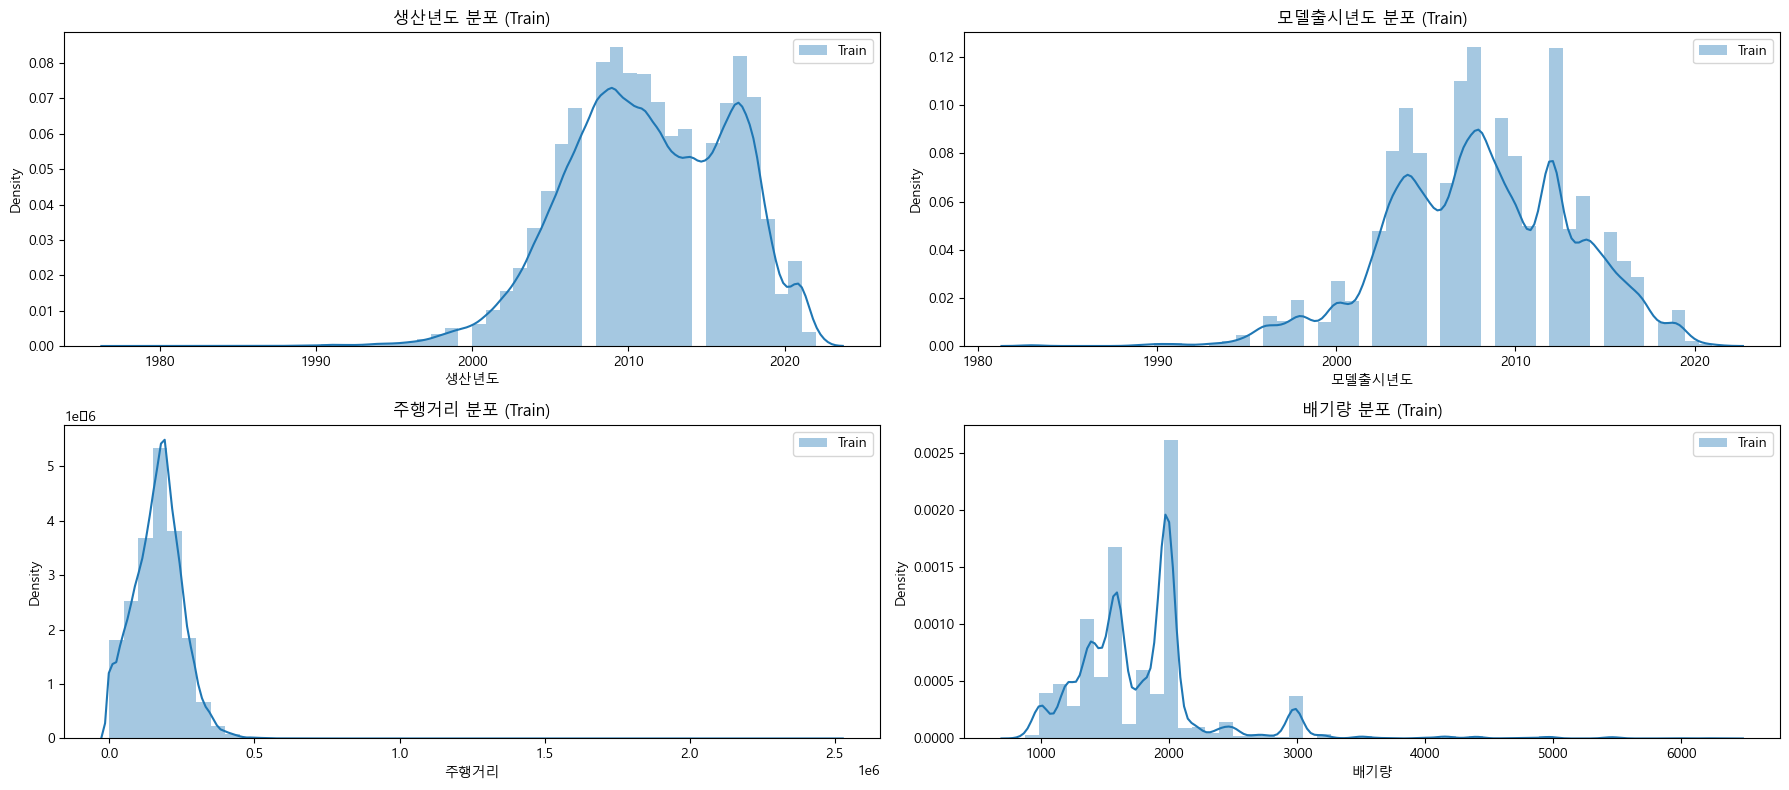

In [20]:
plot_histograms(train[numeric_cols], '가격', 2)

In [21]:
def plot_distribution(df, hue, title='', drop_cols=[]):
    cols = df.columns.drop([hue] + drop_cols)
    n_cols = 3
    n_rows = (len(cols) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows))

    for i, var_name in enumerate(cols):
        row = i // n_cols
        col = i % n_cols

        ax = axes[row, col]
        sns.histplot(data=df, x=var_name, kde=True, ax=ax, hue=hue) # sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')
        ax.set_title(f'{var_name} 분포')

    fig.suptitle(f'{title} 분포 Plot by {hue}', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()

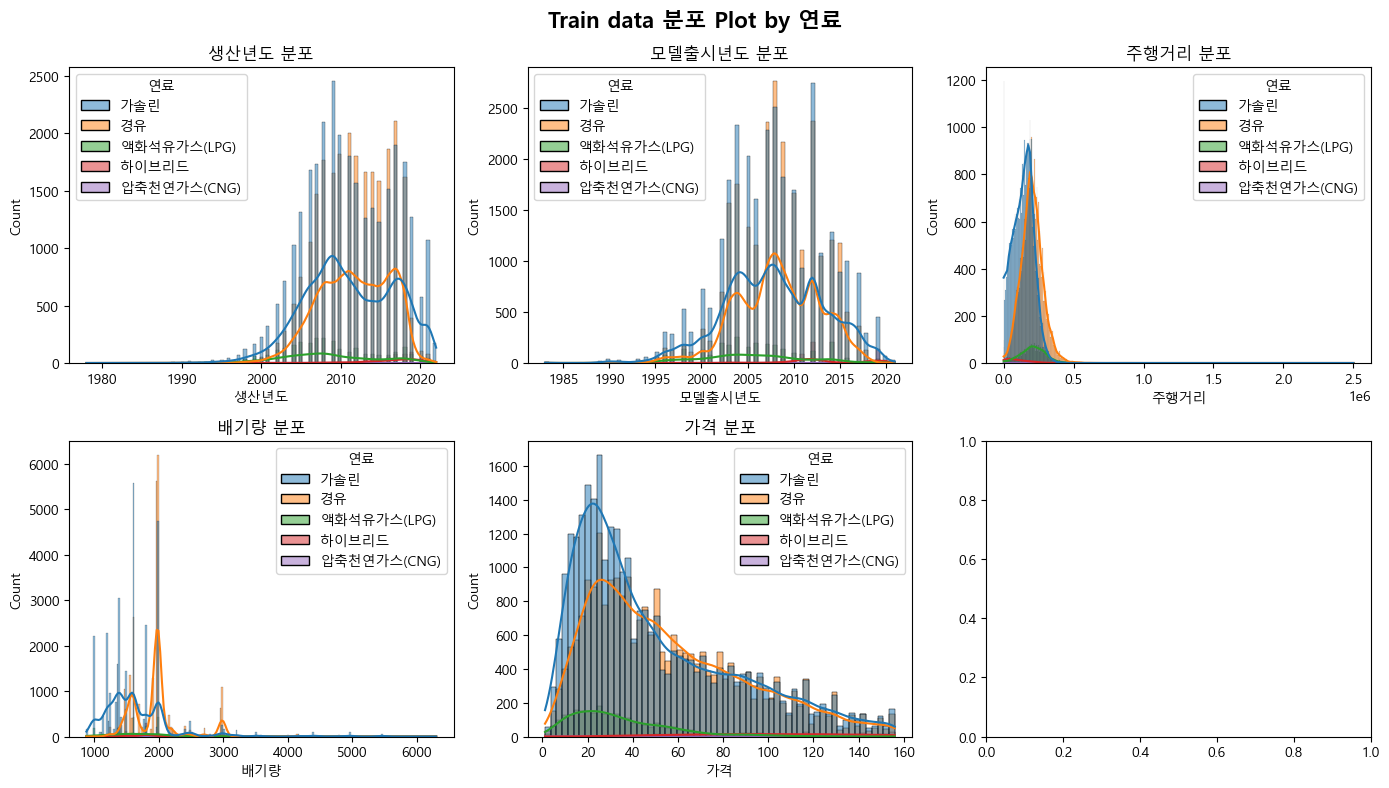

In [23]:
plot_distribution(train, hue='연료', title='Train data', drop_cols=object_cols)